# Análise de Integridade e Qualidade dos Dados (Camada Bronze)
Esta etapa consiste na análise do dado bruto (Raw Data) para identificar a "saúde" da base de dados antes de qualquer processo de ETL. Seguindo a Arquitetura de Medalhão, este notebook cumpre o papel de documentar inconsistências na camada Bronze para orientar a limpeza que ocorrerá na camada Silver.
Abaixo estão listados os listados os códigos em python responsáveis por gerar os gráficos de algumas métricas para nortear a limpeza dos dados na silver e a explicação mais detalhada sobre o motivo do uso de tais gráficos.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('data_raw.csv')

df.columns = df.columns.str.strip() # aqui nós limpamos os espaços em branco no nome das colunas.

# 1.Verificação dos Dados Nulos e Completude dos Dados
A análise de dados nulos é fundamental para garantir que a Camada Prata (Silver) não contenha lacunas que enviesem as consultas SQL posteriores.

**Finalidade:** Identificar colunas com baixa densidade de dados e decidir entre a exclusão da coluna ou a imputação de valores no ETL.

**Importância para o ETL:** Não há sentido em enviar colunas totalmente vazias ou nulas para o ETL.

**Observação:** Colunas como Unnamed: 21 foram identificadas como 100% nulas e serão descartadas.

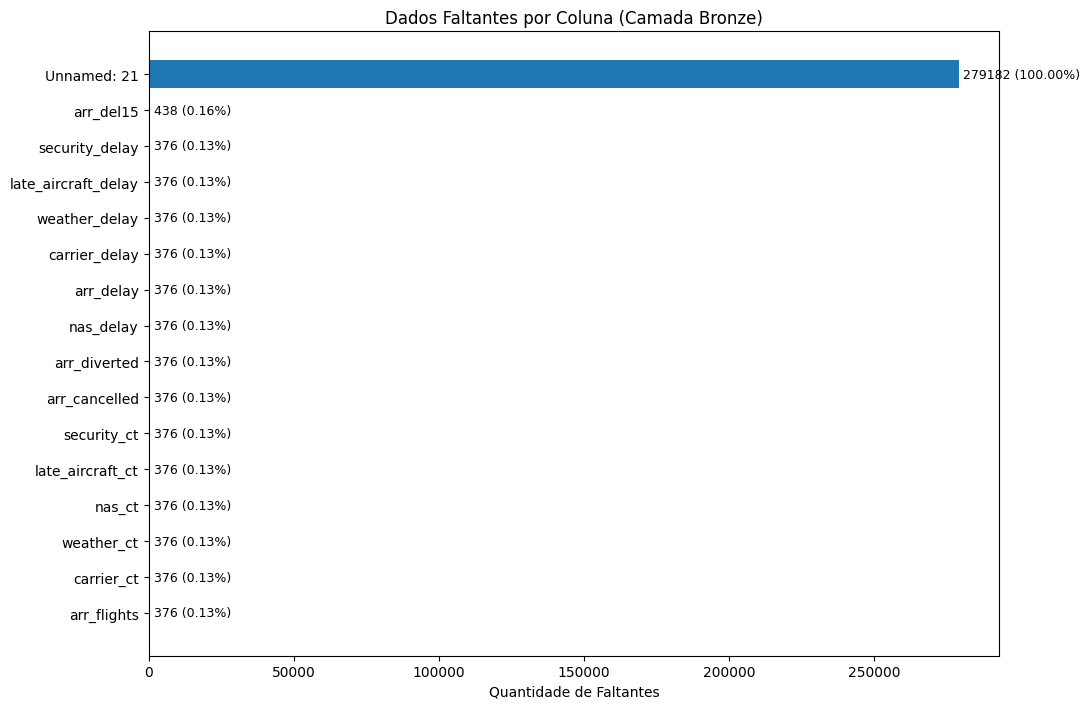

In [8]:
obj = df.select_dtypes("object")
falt = df.isna() | (obj.fillna("").astype(str).apply(lambda s: s.str.strip().eq("")).reindex(df.columns, axis=1, fill_value=False))

nulos = falt.sum()
pct = nulos / len(df) * 100
s = nulos[nulos > 0].sort_values()

fig, ax = plt.subplots(figsize=(11, max(4, 0.45 * len(s))))
bars = ax.barh(s.index, s.values)
ax.set_title("Dados Faltantes por Coluna (Camada Bronze)")
ax.set_xlabel("Quantidade de Faltantes")
ax.bar_label(bars, labels=[f"{int(v)} ({pct[c]:.2f}%)" for c, v in s.items()], padding=3, fontsize=9)
plt.tight_layout()
plt.show()


# 2.Verificação de Registros Duplicados

**Gráfico:**Barras

**Finalidade:** Identificar se há redundância no CSV original(Linhas duplicadas).

**Importância para o ETL:** A existência de duplicados na camada Bronze pode gerar métricas infladas no Dashboard final. O ETL de Raw to Silver será responsável por "limpar esses dados", logo precisamos verificar.

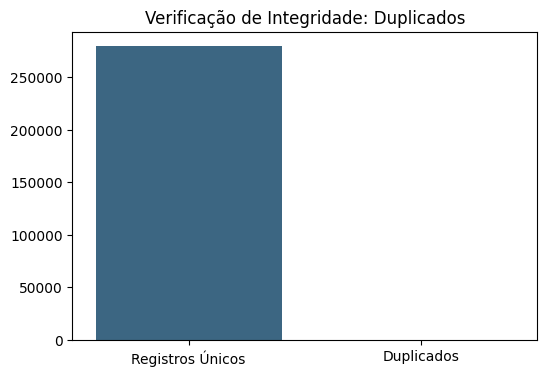

Foram encontrados 0 registros duplicados.


In [9]:
total_duplicados = df.duplicated().sum()

# Representação visual simples
plt.figure(figsize=(6, 4))
nomes = ['Registros Únicos', 'Duplicados']
valores = [len(df) - total_duplicados, total_duplicados]

sns.barplot(x=nomes, y=valores, hue=nomes, palette='viridis', legend=False)
plt.title('Verificação de Integridade: Duplicados')
plt.show()

print(f"Foram encontrados {total_duplicados} registros duplicados.")


# 3.Verificar Outliers

3. Identificação de Outliers (Dados Fora da Curva)

**Gráfico:** Box Plot.

**Finalidade**: Detectar valores extremos (como os atrasos superiores a 400.000 minutos observados) para avaliar se são erros de entrada de dados ou eventos reais de cauda longa.

**Importância para o ETL:** Identificar se há algum dado muito discrepante que possa comprometer nossos dashboards na camada **gold**, por exemplo.

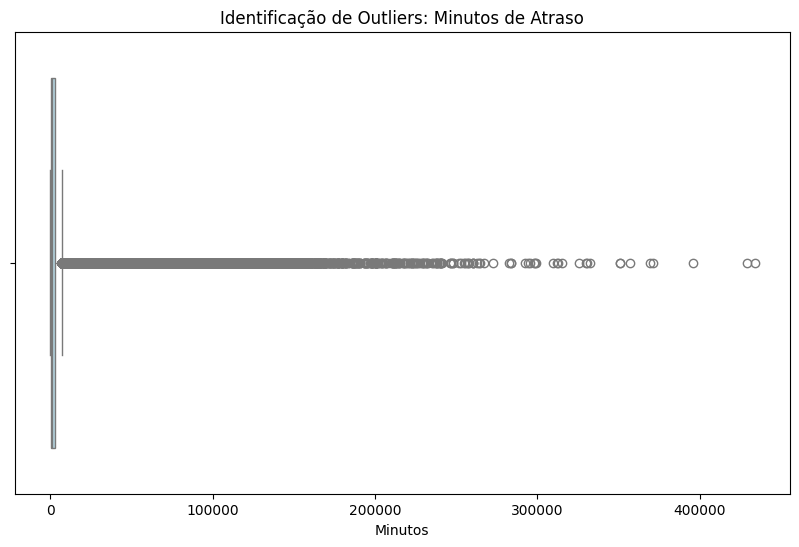

In [10]:
# Analisando outliers na coluna de atraso total
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['arr_delay'], color='lightblue')
plt.title('Identificação de Outliers: Minutos de Atraso')
plt.xlabel('Minutos')
plt.show()

## 4. Análise de Distribuição (Histograma)

**Gráfico**: Histograma.

**Finalidade:** Visualizar a concentração do volume de voos (`arr_flights`) por registro.

**Importância para o ETL:** Identificar se a maioria dos registros representa aeroportos de pequeno, médio ou grande porte, o que auxilia na definição de estratégias de particionamento na camada **Gold**.


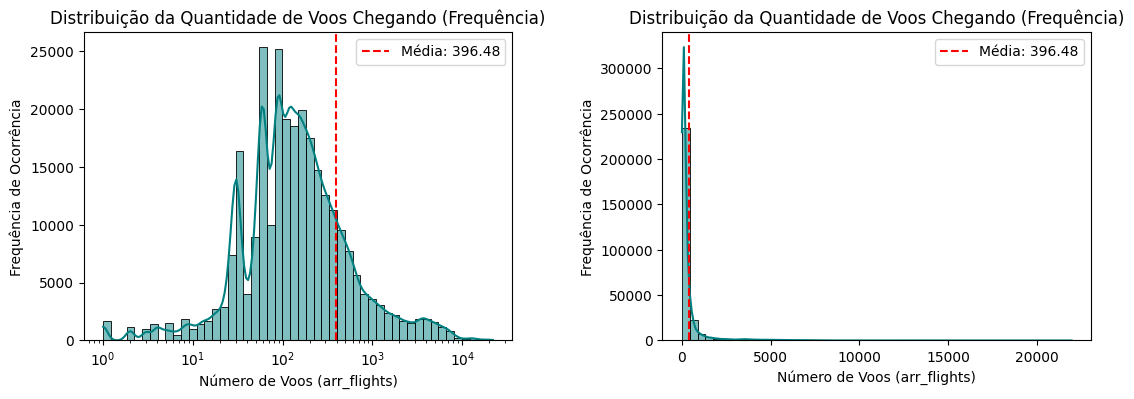

In [11]:
plt.figure(figsize=(13, 4))
# Log
plt.subplot(1, 2, 1)
sns.histplot(df['arr_flights'].dropna(), bins=50, kde=True, color='teal', log_scale=True)

plt.title('Distribuição da Quantidade de Voos Chegando (Frequência)')
plt.xlabel('Número de Voos (arr_flights)')
plt.ylabel('Frequência de Ocorrência')

plt.axvline(df['arr_flights'].mean(), color='red', linestyle='--', label=f'Média: {df["arr_flights"].mean():.2f}')
plt.legend()

# Linear
plt.subplot(1, 2, 2)
sns.histplot(df['arr_flights'].dropna(), bins=50, kde=True, color='teal')

plt.title('Distribuição da Quantidade de Voos Chegando (Frequência)')
plt.xlabel('Número de Voos (arr_flights)')
plt.ylabel('Frequência de Ocorrência')

plt.axvline(df['arr_flights'].mean(), color='red', linestyle='--', label=f'Média: {df["arr_flights"].mean():.2f}')
plt.legend()

plt.subplots_adjust(wspace=0.35)  # aumenta o espaçamento entre os gráficos
plt.show()

## 5. Análise da Correlação de Atrasos

**Gráfico:** Matriz de correlação.

**Finalidade:** Visualizar quais colunas se relacionam mais para causar atrasos.

**Importância para o ETL:** Servirá para comparar essa métrica de causa de atraso entre o dado sujo (raw) e o dado limpo na silver.


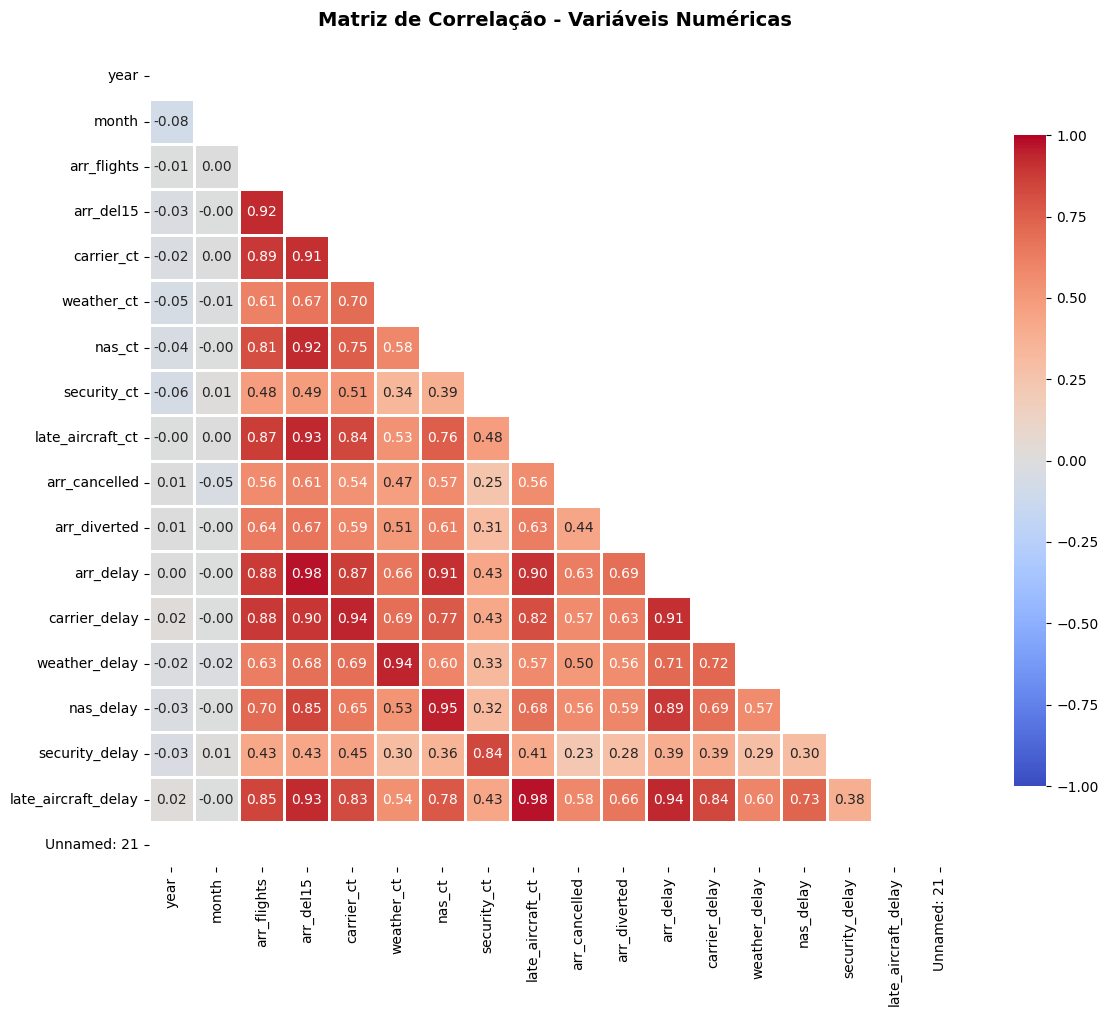

TOP 10 CORRELAÇÕES MAIS FORTES (em valor absoluto)


,Variável_1,Variável_2,Correlação,Abs_Correlação
107,late_aircraft_ct,late_aircraft_delay,0.976033,0.976033
52,arr_del15,arr_delay,0.975064,0.975064
88,nas_ct,nas_delay,0.950937,0.950937
65,carrier_ct,carrier_delay,0.943782,0.943782
77,weather_ct,weather_delay,0.939772,0.939772
125,arr_delay,late_aircraft_delay,0.937098,0.937098
49,arr_del15,late_aircraft_ct,0.930341,0.930341
57,arr_del15,late_aircraft_delay,0.925938,0.925938
47,arr_del15,nas_ct,0.924538,0.924538
31,arr_flights,arr_del15,0.923012,0.923012



✓ Heatmap de correlação gerado para 18 variáveis numéricas


In [12]:
# Matriz de correlação e heatmap

def get_numeric_cols(df):
    """Retorna lista de colunas numéricas (int64, float64)"""
    return df.select_dtypes(include=[np.number]).columns.tolist()

def get_categorical_cols(df):
    """Retorna lista de colunas categóricas (object, category)"""
    return df.select_dtypes(include=['object', 'category']).columns.tolist()


numeric_cols = get_numeric_cols(df)

if len(numeric_cols) >= 2:
    # Calcular correlação
    corr_matrix = df[numeric_cols].corr()
    
    # Plotar heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para mostrar apenas triângulo inferior
    
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
        vmin=-1,
        vmax=1
    )
    
    plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Identificar correlações mais fortes (excluindo diagonal)
    print("=" * 80)
    print("TOP 10 CORRELAÇÕES MAIS FORTES (em valor absoluto)")
    print("=" * 80)
    
    # Criar DataFrame com pares de correlação
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if not np.isnan(corr_value):
                corr_pairs.append({
                    'Variável_1': col1,
                    'Variável_2': col2,
                    'Correlação': corr_value,
                    'Abs_Correlação': abs(corr_value)
                })
    
    if corr_pairs:
        corr_df = pd.DataFrame(corr_pairs).sort_values('Abs_Correlação', ascending=False).head(10)
        display(corr_df)
    else:
        print("Nenhuma correlação válida encontrada.")
    
    print(f"\n✓ Heatmap de correlação gerado para {len(numeric_cols)} variáveis numéricas")
else:
    print(f"Número insuficiente de variáveis numéricas ({len(numeric_cols)}) para análise de correlação. Necessário ≥ 2.")